# Data wrangling: CSV to NetCDF
A user came to us as she had issues with some model outputs. The model outputs to CSV. That's a land model, so there are outputs only on the land points. The data is organised as so for each point, the data for each successive year is in a new row and the data for each month is in the column of this month (Jan, Feb, etc.) for that row. See below the output after reading in the data to make it clearer.

She wanted to store the data in a (lat, lon, time) netcdf file. She would like the longitude and latitude to cover both the land and ocean (it's a 0.5° regular grid) and we also need to figure out how to combine the year and month information into one time information.

Xarray does not read in CSV, we will need to read in the file with Pandas and then figure out how to convert it to DataArray and write it to NetCDF.

## Get the data and dimensions

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
fname = "/g/data/w35/lt0205/research/lpj_guess/runs/CRUNCEP/mgpp.out"
df = pd.read_csv(fname, header=0, delim_whitespace=True)
df

,Lon,Lat,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,39.75,-1.25,1901,0.040,0.039,0.069,0.144,0.056,0.022,0.017,0.005,0.031,0.027,0.132,0.204
1,39.75,-1.25,1902,0.158,0.014,0.052,0.086,0.099,0.046,0.013,0.011,0.024,0.086,0.221,0.089
2,39.75,-1.25,1903,0.012,0.010,0.024,0.140,0.056,0.038,0.015,0.015,0.038,0.020,0.033,0.096
3,39.75,-1.25,1904,0.046,-0.002,0.020,0.051,0.111,0.032,0.004,-0.001,0.024,0.048,0.130,0.049
4,39.75,-1.25,1905,0.035,0.000,0.166,0.164,0.100,0.039,0.022,0.020,0.010,0.024,0.169,0.110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806845,92.75,40.75,2011,0.000,0.000,0.004,0.005,0.001,0.019,0.001,0.001,0.001,0.003,0.003,0.000
6806846,92.75,40.75,2012,0.000,0.000,0.003,0.005,0.000,0.020,0.022,0.008,0.020,0.003,0.001,0.000
6806847,92.75,40.75,2013,0.000,0.000,0.008,0.001,0.008,0.017,0.016,0.021,0.001,0.002,0.002,0.000
6806848,92.75,40.75,2014,0.000,0.000,0.000,-0.000,-0.000,0.004,0.027,0.004,0.001,0.003,0.003,0.000


In [3]:
months=list(df.columns)
months=months[3:]

In [4]:
lons = np.unique(df.Lon)
lats = np.unique(df.Lat)
years = np.unique(df.Year)
nyears = len(years)
nrows = len(lats)
ncols = len(lons)
nmonths = 12
lons.sort()
lats.sort()
years.sort()

## Original code.
The person requesting help sent us the codes she wrote to try and solve the issue. We put one of those below to discuss the good and bad of it.

```python
out = np.zeros((ncols, nrows, nyears*nmonths))
for i,lon in enumerate(lons):
    print(i, ncols)
    for j,lat in enumerate(lats):
        #print(j)
        vals = df[(df.Lat == lat) & (df.Lon == lon)].values[:,3:]
        if len(vals)> 0:
            print("Reshape")
            vals = vals.reshape(nyears*nmonths)
            out[i,j,:] = vals

t1 = pd.to_datetime('1/1/1901')
time = t1 + pd.to_timedelta(np.arange(nmonths*nyears), 'M')

ds = xr.Dataset(data_vars={"mgpp":(["y", "x", "time"],out)},
                coords={"lat": (["y"], lats),
                        "lon": (["x"], lons),
                        "time": time})
ds.to_netcdf('test.nc')
```

The good idea in this code is not to loop over the times but only looping over the spatial points. The bad idea is the original dataset only has the land points. So by looping on all (lon, lat) pairs, we are looping over points that do not have any data in the DataFrame.

The original DataFrame has 59190 spatial points (length of the Frame / # of years). The loop goes through 194878 values, i.e about 3 times more than needed. 

So let's estimate the time it needs to run. We'll time the loop for 1 iteration and then multiply by the number of iterations.

In [5]:
%%timeit
out = np.zeros((ncols, nrows, nyears*nmonths))
for i,lon in enumerate(lons[0:1]):
    #print(i, ncols)
    for j,lat in enumerate(lats[0:1]):
        #print(j)
        vals = df[(df.Lat == lat) & (df.Lon == lon)].values[:,3:]
        if len(vals)> 0:
            vals = vals.reshape(nyears*nmonths)
            out[i,j,:] = vals

21.3 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
# Time for total loop in minutes:
(30.8 * nrows*ncols)/1000/60

100.03737333333332

So we need something that runs faster than 100 min.

## First solution: a loop
Instead of looping through all the spatial points of the output array, we can loop through the rows of the DataFrame and find the correct place in the output array to put this data.

First, let's create the output DataArray so we can easily find the location of points using longitude and latitude. Instead of using only the land points, we'll create the array for the full grid directly and fill with NaN.

In [7]:
# Create the axes
time = pd.date_range(start=f'01/{years[0]}',
                   end  =f'01/{years[-1]+1}', freq='M')
# We'll use a generic way to create a regular grid from [-180,180] and
# [-90, 90] when knowing the resolution. Feel free to reuse as needed.
dx = 0.5
Lon = xr.DataArray(np.arange(-180.+dx/2., 180., dx), dims=("Lon"),
                   attrs={"long_name":"longitude", "unit":"degrees_east"})
nlon = Lon.size
dy = 0.5
Lat = xr.DataArray(np.arange(-90.+dy/2., 90., dy), dims=("Lat"),
                   attrs={"long_name":"latitude", "unit":"degrees_north"})
nlat = Lat.size

In [8]:
out = xr.DataArray(np.zeros((nlat, nlon, nyears*nmonths)),
                   dims=("Lat","Lon","Time"),
                   coords=({"Lat":Lat, "Lon":Lon, "Time":time}))
out[:] = np.nan
out

<xarray.DataArray (Lat: 360, Lon: 720, Time: 1380)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * Lat      (Lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * Lon      (Lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * Time     (Time) datetime64[ns] 1901-01-31 1901-02-28 ... 2015-12-31

First an example with 1 row to see what's happening.
In that case, we would loop over each row and find the location of the data in the dataarray. That would mean a loop over 6.8M items!

We use the longitude, latitude and year information contain in each row to find the locations to update in the `out` array using `loc`. 

In [9]:
%%timeit
row = next(df.iterrows())[1]
out.loc[dict( 
        Lon=row["Lon"],
        Lat=row["Lat"],
        Time=out.Time[(out.Time.dt.year==row["Year"])])] = row[3:]

350 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# Just a check
print(out.sel(Lon=39.75, Lat=-1.25, Time=slice("1901", "1902")))

<xarray.DataArray (Time: 24)>
array([0.04 , 0.039, 0.069, 0.144, 0.056, 0.022, 0.017, 0.005, 0.031,
       0.027, 0.132, 0.204,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan])
Coordinates:
    Lat      float64 -1.25
    Lon      float64 39.75
  * Time     (Time) datetime64[ns] 1901-01-31 1901-02-28 ... 1902-12-31


We see only the data for the year 1901 has been updated for this point only in `out`.

The different notation for Time and the longitude or latitude is because we only look for one longitude and one latitude but we need several time indexes.

But this is way to slow. It's 308ms times the number of rows (6.8M). 

To improve that time, we have to remember all the years for each point are together in order. So we could read nyears at a time and get the data for all years and months at once.

There is still the problem, if we select all years for a point at once, we get a 2D Dataframe with the years in rows and the months in columns. To solve this, we can simply stack the Dataframe over the months columns. Since Pandas doesn't scramble rows when stacking, we can stack the original Dataframe and then use the fact all points have data for the same number of years and months. If we had some missing years for some points, we could modify the following code to allow for it but it would be slower.

In [11]:
# We stack the months columns of the whole DataFrame at once since we
# don't have missing years for any point. Doing it once will save time.
df_stack = df[months].stack()

In [12]:
%%timeit
#Example for one spatial point
rows = df[0:nyears]
# If we had missing years, we could add the missing years rows and then
# stack only the rows for the point here.
#rows_stack = rows[months].stack()
out.loc[dict( 
        Lon=rows["Lon"].min(),
        Lat=rows["Lat"].min())] = df_stack[0:nyears*nmonths]

2.07 ms ± 88.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


If each pack is 2.07 ms, then for the whole DataFrame we need 2 min (see below) which is very good!

In [13]:
len(df.index)//nyears*2.07/1000/60

2.042055

In [14]:
%%time
#df_stack = df[months].stack()
for nr in range(0,len(df.index),nyears):
    rows = df[nr:nr+nyears]
    thislon = rows["Lon"].min()
    thislat = rows["Lat"].min()
    out.loc[dict( 
            Lon=thislon,
            Lat=thislat)] = df_stack[nr*nmonths:(nr+nyears)*nmonths]

CPU times: user 1min 5s, sys: 552 ms, total: 1min 5s
Wall time: 1min 5s


And a plot to check.

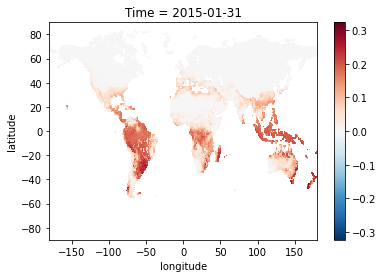

In [15]:
out.sel(Time="2015-01").plot()

# Another solution: groupby
In the loop above, we see we handle all the data for each spatial point at once. That's typically what groupby would do if applied to Lon and Lat. Once we group the data per spatial point, we need to apply a function. This function sould return the stacked data for that point (i.e. the timeseries) with the timestamp as an index. This way to overall DataFrame resulting from the groupby will have Lon, Lat and Time as indexes and 1 column of data. This column will be the timeseries at each point stack one after the other. Let's see what it would look like:

In [16]:
# We reuse the time array we used for defining the out DataArray
# time = pd.date_range(start=f'01/{years[0]}',
#                   end  =f'01/{years[-1]+1}', freq='M')

def time_to_date(df):
    df_stack = df[months].stack()
    return(pd.DataFrame(df_stack.values, index=time))

In [17]:
%%time
df2 = df.groupby(["Lon","Lat"]).apply(time_to_date)

CPU times: user 2min 8s, sys: 2.63 s, total: 2min 10s
Wall time: 2min 10s


In [18]:
df2.index.names = ["Lon", "Lat", "Time"]
df2

0
Lon     Lat   Time           
-179.75 66.25 1901-01-31  0.0
              1901-02-28  0.0
              1901-03-31  0.0
              1901-04-30  0.0
              1901-05-31  0.0
...                       ...
 179.75 71.25 2015-08-31  0.0
              2015-09-30  0.0
              2015-10-31  0.0
              2015-11-30  0.0
              2015-12-31  0.0

[81682200 rows x 1 columns]

We see the groupby calculation takes about the same time but we only get a DataFrame as output and not a DataArray. So we still need to convert this DataFrame to a DataArray. Unfortunately, the conversion below crashes the Jupyter Kernel. This is because the DataFrame contains only the landpoints. The DataArray created would be sparse with irregular coordinates. There are ways to solve this issue but we'll see those in another blog on sparse matrices as this one is long enough. 

In [ ]:
#out = df2.to_xarray()

## Conclusion
Although the code with `groupby` is a lot more compact, it might not be as intuitive to write at first. In this case, it shows a well-thought loop can actually be faster than a `groupby` as the conversion to a spatially full DataArray can be done at the same time as the concatenation of the months and years.

At the opposite, after experience using Pandas and Xarray, the `groupby` solution might be the first one will think about. It isn't a bad solution but then one needs to know how to fill the missing indexes.

# Solution summary
Below is the solution with the loop containing only the necessary code in one cell to clarify what the final code would look like.

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr

fname = "/g/data/w35/lt0205/research/lpj_guess/runs/CRUNCEP/mgpp.out"
df = pd.read_csv(fname, header=0, delim_whitespace=True)

months=list(df.columns)
months=months[3:]
years = np.unique(df.Year)
nyears = len(years)
nmonths = 12
years.sort()

# Create the axes
time = pd.date_range(start=f'01/{years[0]}',
                   end  =f'01/{years[-1]+1}', freq='M')
# We'll use a generic way to create a regular grid from [-180,180] and
# [-90, 90] when knowing the resolution. Feel free to reuse as needed.
dx = 0.5
Lon = xr.DataArray(np.arange(-180.+dx/2., 180., dx), dims=("Lon"),
                   attrs={"long_name":"longitude", "unit":"degrees_east"})
nlon = Lon.size
dy = 0.5
Lat = xr.DataArray(np.arange(-90.+dy/2., 90., dy), dims=("Lat"),
                   attrs={"long_name":"latitude", "unit":"degrees_north"})
nlat = Lat.size

# Output array
out = xr.DataArray(np.zeros((nlat, nlon, nyears*nmonths)),
                   dims=("Lat","Lon","Time"),
                   coords=({"Lat":Lat, "Lon":Lon, "Time":time}))
out[:] = np.nan

# We stack the months columns of the whole DataFrame at once since we
# don't have missing years for any point. Doing it once will save time.
df_stack = df[months].stack()

for nr in range(0,len(df.index),nyears):
    rows = df[nr:nr+nyears]
    thislon = rows["Lon"].min()
    thislat = rows["Lat"].min()
    out.loc[dict( 
            Lon=thislon,
            Lat=thislat)] = df_stack[nr*nmonths:(nr+nyears)*nmonths]
 
out.sel(Time="2015-01").plot()